In [2]:
from schemes import * 
from tools import *
from fourier_adams import * 

### I. Rough Heston model 

We develop experiments for the rough Heston model, which has the following form:\begin{align*}
    dS_t &= S_t\sqrt{V_t}dB_t,\\
    V_t &= V_0 + \displaystyle\int_0^t K(t-s)\kappa(\theta-V_s)\,ds + \int_0^t K(t-s)\nu\sqrt{V_s}\, dW_s,\\
    d\langle B,W\rangle_t &= \rho\, dt,
\end{align*}
where the fractional kernel is defined as $K(t) := \dfrac{t^{\alpha-1}}{\Gamma(\alpha)}$, $\alpha \in (1/2,1)$, where $\alpha = H+1/2$. For the simulations, we adapt the so-called *hybrid scheme* from [M. Bennedsen, A. Lunde and M.S. Pakkanen (2017)](https://arxiv.org/pdf/1507.03004).

In [38]:
S0, V0 = 1, 0.04
kappa, theta, nu, rho = 1.0, 0.06, 0.1, -0.7
H = 0.1
alpha = H+0.5
r = 0
T = 0.1
n = 252
M = 10000

In [40]:
N_vals = simulate_antithetic(M, n, d=3)
S, V = simulate_rough_heston(M, n, T, S0, V0, kappa, theta, nu, rho, H, N_vals)

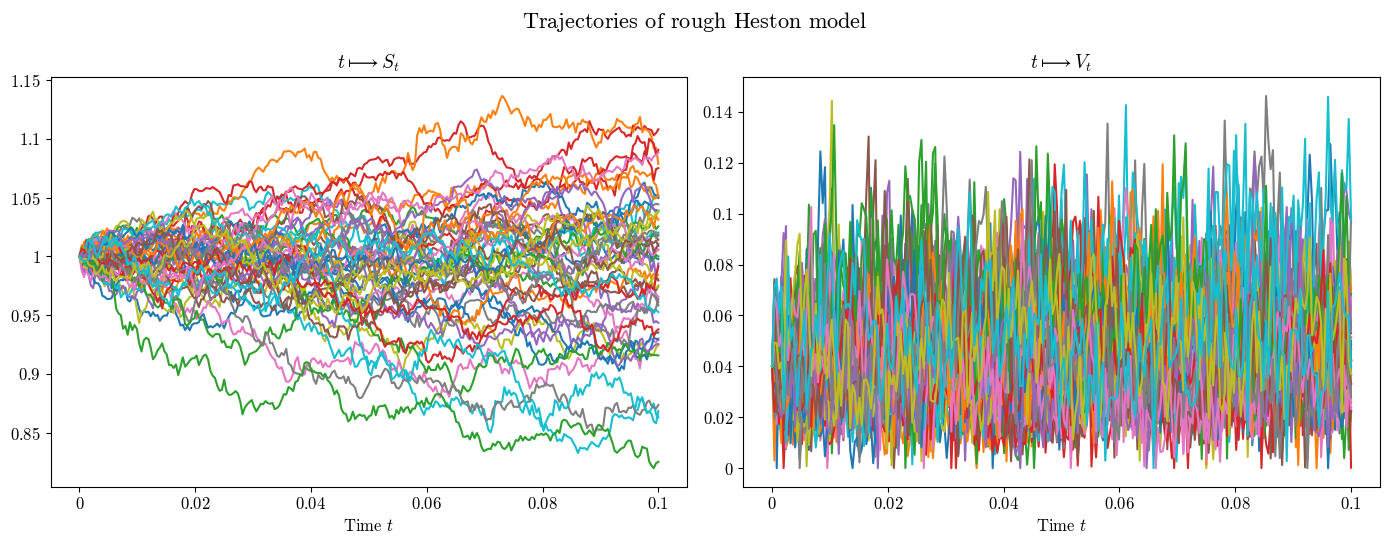

In [41]:
plot_trajectories_rough_Heston(S[:50], V[:50], T, n) 

[O. El Euch and M. Rosenbaum](https://arxiv.org/pdf/1609.02108) showed that, similarly to the standard Heston model $(H = 0.5)$, the characteristic function of the log-stock price can be computed in semi-closed form, and the next section details this, as well as a numerical scheme, that we use for comparisons.

### II. Fourier 

<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);"> 
    <strong>Theorem.</strong> For $t\geq 0$, $\phi_t : \mathbb R \longmapsto \mathbb C$ denotes the characteristic function $$\phi_t(u) = \mathbb{E}\left[\left.e^{iu\ln \frac{S_T}{S_t}}\right|\mathscr{F}_t\right] = e^{\kappa\theta \mathfrak J^1 h(u,t) + V_0 \mathfrak{J}^{1-\alpha}h(u,t)},$$
where, for any $u\in \mathbb R$, $h(u,t)$ solves the fractional Riccati equation: 
    $$\mathfrak D^\alpha h(u,t) = \mathfrak{F}(u, h(u,t)), \quad \mathfrak{J}^{1-\alpha}h(u,0) = 0, \quad \mathfrak F(u,x) :=- \frac{u(u+i)}{2} + (iu\rho\nu - \kappa)x + \frac{\nu^2x^2}{2}.$$
</div>   

In practice, we implemented the Adams scheme as in [O. El Euch and M. Rosenbaum](https://arxiv.org/pdf/1609.02108).

<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);"> 
    <strong>Lewis formula.</strong> Let us consider a European call option on $S$ with maturity $T  > 0$ and strike $K>0$. Its price at time $t\leq T$ is given by $C_t(T,K) = \mathbb E\left[(S_T-K)^+\big|\mathscr F_t\right]$. From Lewis, one can price this option using the Fourier inversion formula
    \begin{align*}C_t(S_t, T, K) &= S_t - \frac{K}{\pi}\int_0^\infty \Re\left[e^{i\left(u-\frac i2\right)k_t}\phi_t\left(u-\frac i2\right)\right]\frac{du}{u^2+\frac14},
    \end{align*}
    with $k_t = \ln \frac{S_t}{K}$.
</div>   

Moreover, we add a "control variate" to quicken the convergence. Given $\sigma_\text{BS} < \infty$, one has 
\begin{align*}C_t(S_t, T, K)
&= C_t^\text{BS}(S_t, T, K) - \frac{K}{\pi}\int_0^\infty \Re\left[e^{i\left(u-\frac i2\right)k_t}\left(\phi_t\left(u-\frac i2\right) - \phi_t^\text{BS}\left(u-\frac i2\right)\right)\right]\dfrac{du}{u^2+\frac14}\end{align*}
with $C_t^\textnormal{BS}(S_t, T, K) = S_t \mathcal N(d_1)  - K\mathcal{N}(d_2)$, $$d_1 = \dfrac{\ln \frac{S_t}{K} + \frac{\sigma_\text{BS}^2}{2}(T-t)  }{\sigma_\text{BS}\sqrt{T-t}}, \quad d_2 = d_1 - \sigma_\text{BS}\sqrt{T-t}, \quad \phi_t^\text{BS}(u) = e^{-\frac{\sigma_\text{BS}^2}{2}(u^2+iu)(T-t)}.$$

In practice, the quantitity $\sigma_\text{BS}$ can be determinaed to ensure approximate moment matching for instance, and one can use the characteristic function $\phi_t$ to approximate (by finite difference) the second order cumulant of the distribution of the log price $\ln S$. Numerically, for the discretization of the Fourier integral, we will use the Gauss-Laguerre quadrature with $L$ nodes, which outperform other quadrature rules in this setting.

The control variate is therefore particularly beneficial when $L$ is small or moderate, or when the characteristic function is costly to evaluate, as in rough volatility models. For sufficiently large $L$, the Gauss–Laguerre quadrature alone already provides high accuracy, and the additional gain from the control variate becomes marginal. Let us illustrate this fact with $L = 5, 50$. 

In [50]:
lm_range = np.linspace(-0.4, 0.4, 20)
K_values = S0 * np.exp(lm_range)

N_vals = simulate_antithetic(M, n, d=3)
S, _ = simulate_rough_heston(M, n, T, S0, V0, kappa, theta, nu, rho, H, N_vals)

prices_mid, prices_lower, prices_upper = compute_prices_europ_MC(S[:, -1], K_values)

#### II.1. $L = 50$

In [52]:
L = 50
phi = compute_phi(T, n, alpha, V0, kappa, theta, nu, rho, L) 

In [53]:
prices_fourier = compute_prices_europ_Fourier(phi, S0, K_values, flag="call")
sigma_BS = get_sigma_BS(T, n, alpha, V0, kappa, theta, nu, rho) 
prices_fourier_CV = compute_prices_europ_Fourier_with_control_variate(phi, S0, K_values, T, sigma_BS, flag="call")

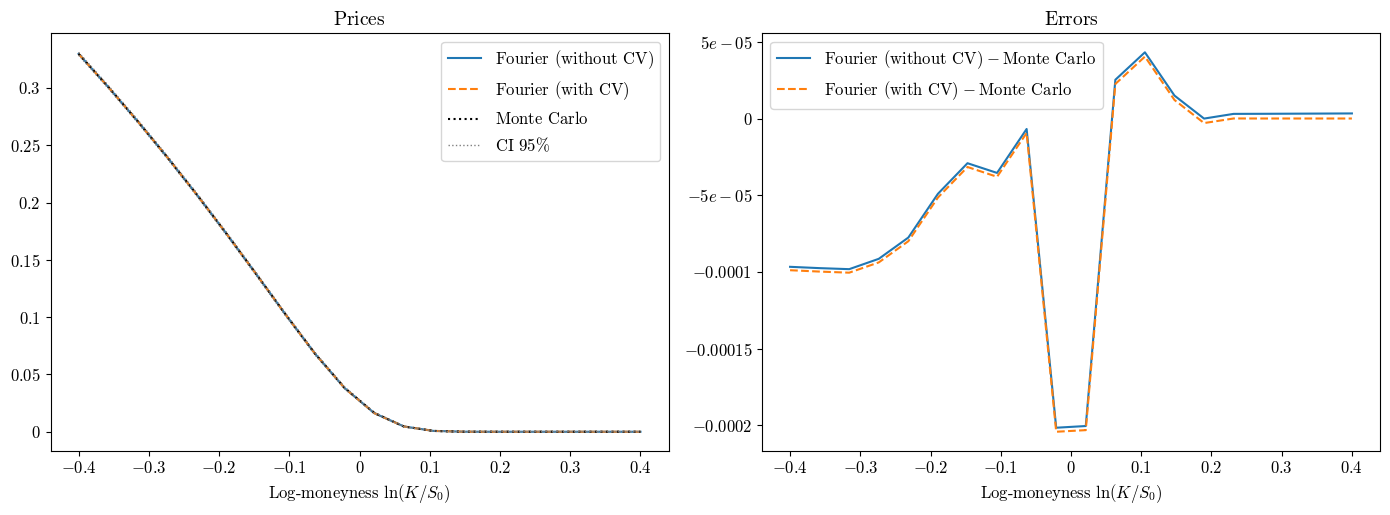

In [54]:
plot_prices_only_Fourier(lm_range, prices_mid, prices_lower, prices_upper, prices_fourier, prices_fourier_CV, save=False) 

#### II.2. $L = 5$

In [56]:
L = 5
phi = compute_phi(T, n, alpha, V0, kappa, theta, nu, rho, L) 

In [57]:
prices_fourier = compute_prices_europ_Fourier(phi, S0, K_values, flag="call")
sigma_BS = get_sigma_BS(T, n, alpha, V0, kappa, theta, nu, rho) 
prices_fourier_CV = compute_prices_europ_Fourier_with_control_variate(phi, S0, K_values, T, sigma_BS, flag="call")

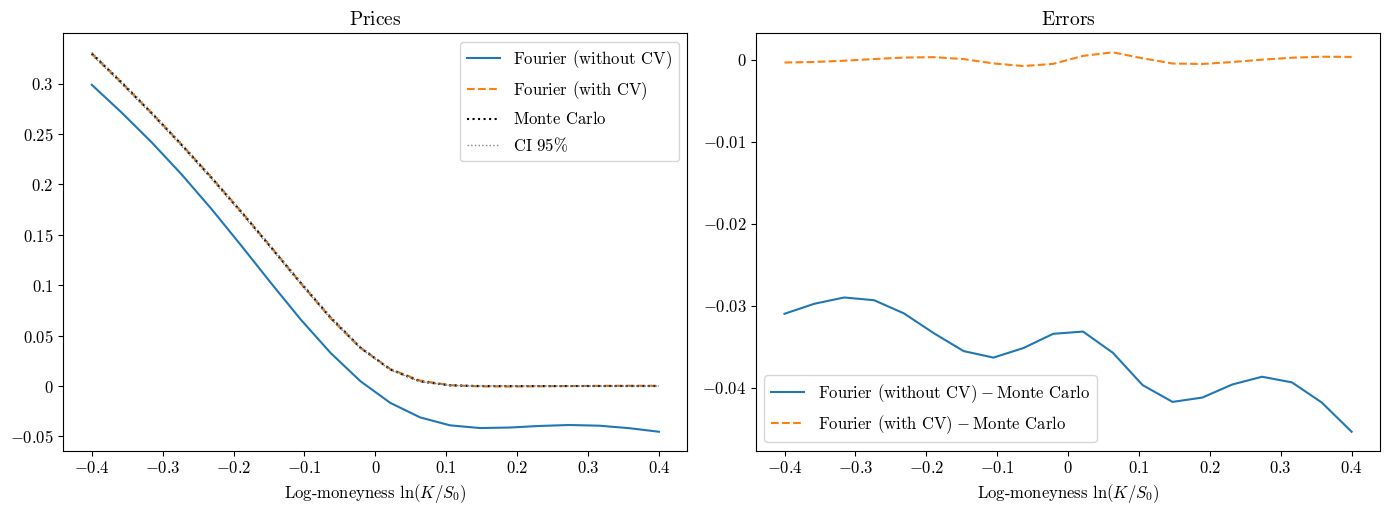

In [58]:
plot_prices_only_Fourier(lm_range, prices_mid, prices_lower, prices_upper, prices_fourier, prices_fourier_CV) 